# PHATE

In this approach, we use phate to estimate a diffusion kernel, and then we use the distances from that kernel to form the ontology.

In [1]:
import pandas as pd
import numpy as np
import phate
import scipy.spatial.distance as distance

# Here the scaled with the embeddings are loaded. Change the file to load
# embeddings from a different language model.
scales = pd.read_csv('embeddings_openAI_large_de.csv')

# select the rows of scales where the scaleID field is "NEO" or "PID"
scales = scales[scales['scaleID'].isin(['NEO', 'PID'])]

# form matrix of embeddings
mx = scales.embedding.apply(eval).to_list()
mx = np.asarray(mx)

# load scales data
data = pd.read_csv('scales_data.csv')

# select the columns of the dataframe data where the column names starts with "PID" or "NEO"
data = data[data.columns[data.columns.str.startswith('PID5BF') | data.columns.str.startswith('NEOFFI')]]

# form the correlation matrix of the scales data
corr_mx = data.corr().values
corr_values = distance.squareform(1 - corr_mx)

# extract the upper triangle of a matrix into a vector
def extract_upper_triangle(matrix):
    n = matrix.shape[0]
    return matrix[np.triu_indices(n, 1)]
corr_values = extract_upper_triangle(corr_mx)

In [10]:
phate_operator = phate.PHATE(n_jobs = -2, gamma = -1, decay = 40, knn = 4, t = 2, n_components = 29, 
                             mds_dist='euclidean', mds = 'nonmetric', mds_solver = 'smacof') 
Y_phate = phate_operator.fit_transform(mx)

# Create a distance matrix from the data matrix mx
dist_values = distance.pdist(Y_phate, metric='euclidean')
dist_mx = distance.squareform(dist_values)


Calculating PHATE...
  Running PHATE on 102 observations and 3072 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.79 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.84 seconds.
  Calculating diffusion potential...
  Calculating nonmetric MDS...


C:\Users\rober\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
C:\Users\rober\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated nonmetric MDS in 0.58 seconds.
Calculated PHATE in 1.43 seconds.


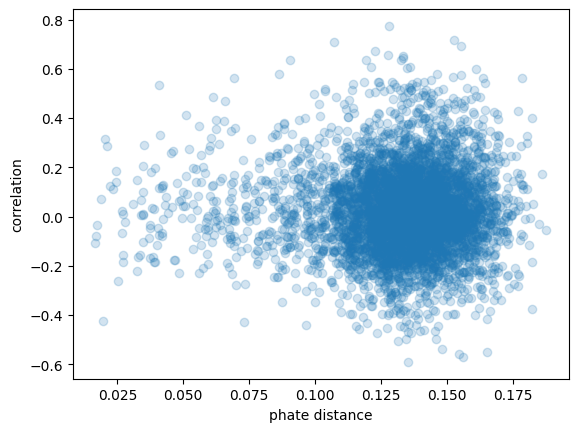

In [11]:

# Print a scatter plot of of dist_values and corr_values
import matplotlib.pyplot as plt
plt.scatter(dist_values, corr_values, alpha = 0.2)
plt.xlabel('phate distance')
plt.ylabel('correlation')
plt.show()

We obtain this result after modifying the default settings for phate. The most important changes are: 1. diffusion degrades the definition of distance and high correlation in data (hence, t = 1), 2. many dimensions are required (to do: use von Neumann entropy to automatically determine dimensions). Alpha decay, in contrast, improves performance (but not by much), as does a small neighbourhood.

This result appears to separate the items with high correlation a bit more from the buld. However, also a few items with no correlation are considered semantically similar. We also do not have the clear association between cosine distance and correlation we had in the raw data. In sum, the geometry of the semantic distance is altered such that distance is no longer a good predictor of correlation of responses.

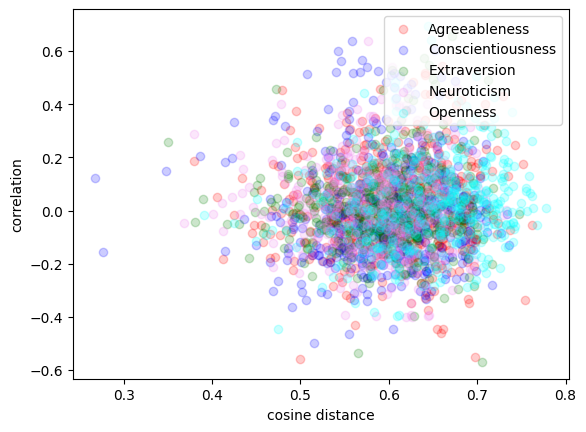

In [12]:
# select rows of mx where scales.scaleID is "NEO"
neo_idx = scales['scaleID'] == 'NEO'
pid_idx = scales['scaleID'] == 'PID'
neo_mx = mx[neo_idx, :]
pid_mx = mx[pid_idx, :]
cdist_mx = distance.cdist(neo_mx, pid_mx, metric='cosine')
ccorr_mx = corr_mx[np.ix_(neo_idx,pid_idx)]

# create a scatter plot of cdist_mx and ccorr_mx
import matplotlib.pyplot as plt
neo_types = pd.Categorical(scales[neo_idx]['type'].values)
colors = ['red', 'blue', 'green', 'violet', 'cyan']
for neoscale, color in zip(neo_types.categories, colors):
    neo_type_idx = neo_types == neoscale
    plt.scatter(cdist_mx[neo_type_idx,:].flatten(), ccorr_mx[neo_type_idx,:].flatten(),
                alpha = 0.2, c = color, label = neoscale)
plt.legend(loc = 1)

plt.xlabel('cosine distance')
plt.ylabel('correlation')
plt.show()
